In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
import tensorflow as tf
import warnings
from sklearn.model_selection import train_test_split
from IPython.display import display
from IPython.display import Image
warnings.filterwarnings('ignore')
import requests
import tarfile

<div class="alert alert-block alert-danger">
<b><h1><center>Final Project - Machine Learning</center></h1></b>
<b><h1><center>Roee Tal - 315858506, Tavor Levine - 315208439</center></h1></b>
</div>


<div class="alert alert-block alert-danger">
                     <font size="30"><h1><center>CIFAR-10</center></h1></font>
    

The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Since the images in CIFAR-10 are low-resolution (32x32x3), this dataset can allow researchers to quickly try different algorithms to see what works. Our goal is to check what is the best model that predict correct. There are 40,000 training images, 10,000 validation images and 10,000 test images.


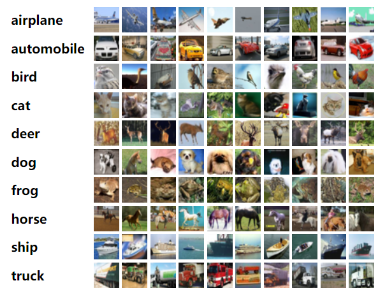

### During the work on the project

1. We loaded the data into the notebook and presented it in two different resolutions
2. We analyzed the data and checked whether it is balanced, arranged and preapare the data 
3. We ran models on the images in RGB format(original).
4. We ran models on the images in GRAY format.
5. We decided to use the PCA method to select the best components for the model and increase the efficiency.
6. We ran the models on the images in RGB format after reducing the components. 
7. We decided to explore the data in a different way. Instead of having 10 classes, we united the groups into 2 classes. Animals VS Vehicles.
8. We ran the models on the updated data.
9. We checked what happens when running a neural network on the data, we used CNN.

### Import the data

In [89]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
response = requests.get(url, stream=True)

with open("cifar-10-python.tar.gz", "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

with tarfile.open("cifar-10-python.tar.gz", "r:gz") as tar:
    tar.extractall()

### Functions

In [85]:
def load_cifar_batch(file_path):
    with open(file_path, 'rb') as file:
        data_dict = np.load(file, encoding='bytes', allow_pickle=True)
    return data_dict

In [71]:
def scale(train,val,test):
    train = train / 255.0
    val = val / 255.0
    test = test / 255.0

In [83]:
def plot_image(num):
    # Specify the path to the CIFAR-10 dataset folder
    dataset_path = './cifar-10-batches-py'

    # Load a batch of CIFAR-10 training data
    batch_file_path = os.path.join(dataset_path, 'data_batch_1')
    batch_data = load_cifar_batch(batch_file_path)

    # Extract the pixel data and labels from the batch
    pixel_data = batch_data[b'data']
    labels = batch_data[b'labels']

    # Reshape the pixel data into image format
    images = pixel_data.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    
    if num is 0:
        upscaled_images = []
        for image in images:
            upscaled_image = Image.fromarray(image).resize((128, 128), Image.BILINEAR)
            upscaled_images.append(np.array(upscaled_image))

    # Display the first few images along with their labels
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))

    for i in range(10):
        if num is 0:
            image = upscaled_images[i]
        else:
            image = images[i]
        label = labels[i]
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [20]:
def plot_confusion_mat(matrix,class_names):
    conf_matrix = pd.DataFrame(data=matrix,index=class_names, columns=class_names)
    plt.figure(figsize = (8,5))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, fmt = "g")

In [650]:
def plot_confusion_mat2(matrix,class_names):
    conf_matrix = pd.DataFrame(data=matrix,index=class_names, columns=class_names)
    plt.figure(figsize = (8,5))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, fmt = "g")

In [86]:
# converting the image to gray scale
def rgb2gray(df):
    return np.dot(df[...,:3], [0.2989, 0.5870, 0.1140])


In [21]:
# For confusion matrix
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Back to the data

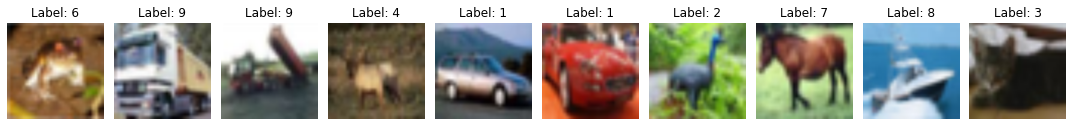

In [422]:
# image with clearer sight
plot_image(0)

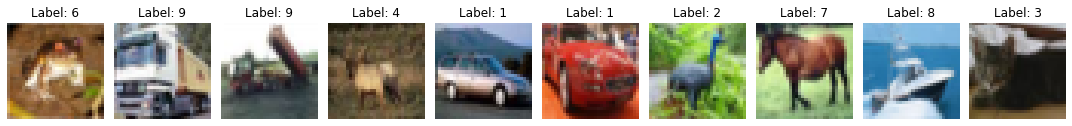

In [423]:
# The original images
plot_image(1)

### The data in dataframe

In [87]:
# Specify the path to the CIFAR-10 dataset folder
dataset_path = './cifar-10-batches-py'

# List to store data from all batches
data_list = []

# Loop through each batch file and load the data
for i in range(1, 6):
    batch_file_path = os.path.join(dataset_path, f'data_batch_{i}')
    batch_data = load_cifar_batch(batch_file_path)

    # Extract the pixel data and labels from the batch
    pixel_data = batch_data[b'data']
    labels = batch_data[b'labels']

    # Reshape the pixel data into image format
    images = pixel_data.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

    # Flatten the images as feature vectors
    num_images = images.shape[0]
    image_size = images.shape[1] * images.shape[2] * images.shape[3]
    flattened_images = images.reshape(num_images, image_size)

    # Create a DataFrame with flattened images and labels
    df_batch = pd.DataFrame(flattened_images)
    df_batch['label'] = labels

    # Append the batch data to the data_list
    data_list.append(df_batch)

# Concatenate all batch DataFrames into a single DataFrame
df = pd.concat(data_list, ignore_index=True)

# Display the concatenated DataFrame
df

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,59,62,63,43,46,45,50,48,43,68,...,216,184,140,151,118,84,123,92,72,6
1,154,177,187,126,137,136,105,104,95,102,...,143,133,139,143,134,142,143,133,144,9
2,255,255,255,253,253,253,253,253,253,253,...,78,85,83,79,85,83,80,86,84,9
3,28,25,10,37,34,19,38,35,20,42,...,54,47,28,63,56,37,72,65,46,4
4,170,180,198,168,178,196,177,185,203,183,...,75,79,82,71,75,78,73,77,80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,145,161,194,151,166,199,156,171,205,155,...,39,41,56,36,38,53,37,39,54,2
49996,255,245,132,254,247,134,255,249,137,254,...,249,174,79,252,181,81,253,181,76,6
49997,35,178,235,40,176,239,42,176,241,39,...,27,52,77,21,43,66,12,31,50,9
49998,189,211,240,186,208,236,185,207,235,184,...,195,184,169,196,189,171,195,190,171,1


### Prepare the data

In [63]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [64]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.2, random_state = 42)

In [65]:
x_train_full.shape

(50000, 32, 32, 3)

In [66]:
x_train.shape

(40000, 32, 32, 3)

### Data Distribution

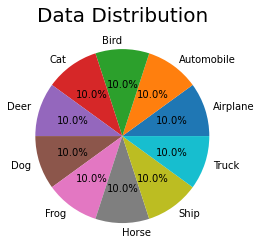

In [558]:
targets_train_series = pd.Series(y_train_full.flatten())
items_dict = dict(targets_train_series.value_counts())
labels = list(items_dict.keys())  # Convert dict_keys to a list
values = list(items_dict.values())  # Convert dict_values to a list
plt.pie(values, labels=['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer','Dog', 'Frog','Horse','Ship','Truck'], autopct='%1.1f%%')
plt.title('Data Distribution' , fontdict = {'fontsize' : 20})
plt.show()

The data is balanced

In [76]:
X_train_rgb = x_train.reshape(x_train.shape[0], -1)
X_val_rgb = x_val.reshape(x_val.shape[0], -1)
X_test_rgb = x_test.reshape(x_test.shape[0], -1)

# convert labels from a 2D array to 1D array
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

In [77]:
# Scaling
scale(X_train_rgb,X_val_rgb,X_test_rgb)

### Functions - Models

In [465]:
def Knn(train,val,y_train,y_val):
    accuracy = []
    for i in range (1,15,2):
        
        model_knn = KNeighborsClassifier(n_neighbors = i)
        model_knn_fit = model_knn.fit(train, y_train)
        model_knn_pred = model_knn.predict(val)
        
        acc_knn = accuracy_score(y_val, model_knn_pred)
        accuracy.append(round(acc_knn,3)*100)

    index = accuracy.index(max(accuracy))+1 
    print("The Accuracy score for " + str(index) +" nearest neighbers is: " + str(max(accuracy)) +"%")
    plt.plot(range(1,15,2),accuracy)
    plt.show()
    
    return model_knn_pred

In [584]:
def LR(train,val,y_train,y_val):
    for i in range(20,150,30):
        model_lr = LogisticRegression(max_iter = i)
        model_lr_fit = model_lr.fit(train, y_train)
        model_lr_pred = model_lr.predict(val)
        model_lr_t = model_lr.predict(train)
        # Accuracy of Model 
        acc_lr = accuracy_score(y_val, model_lr_pred)
        acc_lr_t = accuracy_score(y_train, model_lr_t)
        print(str(i) + " iterations: Validation set - The Accuracy score is: " + str(round(acc_lr,3)*100) +"%")
                
        print(str(i) + " iterations: Training set - The Accuracy score is: " + str(round(acc_lr_t,3)*100) +"%")
    
    return model_lr_pred

In [96]:
def LR2(train,val,y_train,y_val):
    for i in range(20,500,50):
        model_lr = LogisticRegression(max_iter = i)
        model_lr_fit = model_lr.fit(train, y_train)
        model_lr_pred = model_lr.predict(val)
        model_lr_t = model_lr.predict(train)
        # Accuracy of Model 
        acc_lr = accuracy_score(y_val, model_lr_pred)
        acc_lr_t = accuracy_score(y_train, model_lr_t)
        print(str(i) + " iterations: Validation set - The Accuracy score is: " + str(round(acc_lr,3)*100) +"%")
                
        print(str(i) + " iterations: Training set - The Accuracy score is: " + str(round(acc_lr_t,3)*100) +"%")
    
    return model_lr_pred

In [102]:
def SVM(train,val,y_train,y_val):
    accuracy = []
    Kernel = ['poly','rbf']
    c = [0.1,1.0,2.0,5.0]
    for i in range(len(Kernel)):
        for j in range(len(c)):
            # initialize the SVM classifier
            SVM = svm.SVC(max_iter=10000, kernel=Kernel[i], C = c[j])
            
            # fit the SVM classifier on the training data
            SVM.fit(train, y_train)
            
            # make predictions on the validation data
            val_pred = SVM.predict(val)

            # calculate the accuracy score
            svm_acc = accuracy_score(y_val, val_pred)
            accuracy.append(round(svm_acc,3)*100)
            print(Kernel[i], 'kernel with', c[j], 'Regularization parameter gave score of:', svm_acc)
    
    return val_pred

In [113]:
def SVM2(train,val,y_train,y_val):

    accuracy = []
    Kernel = ['poly', 'rbf']
    c = [0.1, 1.0, 2.0, 5.0]
    accuracy_scores = {kernel: {'train': [], 'val': []} for kernel in Kernel}
    
    for i in range(len(Kernel)):
        for j in range(len(c)):
            # Initialize the SVM classifier
            SVM = svm.SVC(max_iter=10000, kernel=Kernel[i], C=c[j])
            
            # Fit the SVM classifier on the training data
            SVM.fit(train, y_train)
            
            # Make predictions on the validation data
            val_pred = SVM.predict(val)
            model_svm_t = SVM.predict(train)
            
            # Calculate the accuracy score
            svm_acc = accuracy_score(y_val, val_pred)
            acc_svm_t = accuracy_score(y_train, model_svm_t)
            accuracy_scores[Kernel[i]]['val'].append(svm_acc)
            accuracy_scores[Kernel[i]]['train'].append(acc_svm_t)
            
            print("Validation:")
            print(Kernel[i], 'kernel with', c[j], 'Regularization parameter gave score of:', svm_acc)
            print("Train:")
            print(Kernel[i], 'kernel with', c[j], 'Regularization parameter gave score of:', acc_svm_t)

        # Create a plot for each kernel (validation accuracy)
        plt.figure(figsize=(10, 6))
        plt.plot(c, accuracy_scores[Kernel[i]]['val'], marker='o', label=Kernel[i] + ' (Validation)')
        plt.plot(c, accuracy_scores[Kernel[i]]['train'], marker='x', label=Kernel[i] + ' (Train)')
        plt.title('SVM Accuracy for ' + Kernel[i] + ' Kernel')
        plt.xlabel('Regularization Parameter (C)')
        plt.ylabel('Accuracy')
        plt.xticks(c)
        plt.legend()
        plt.grid(True)
        plt.show()
    return val_pred


In [588]:
def Decision_tree(train,val,y_train,y_val):
    d_tree = DecisionTreeClassifier(max_depth = 20)
    
    d_tree.fit(train,y_train)
    d_tree_pred = d_tree.predict(val)
    
    acc_d_tree = accuracy_score(y_val,d_tree_pred)
    
    print("The Accuracy score for Decision tree Model is: " + str(round(acc_d_tree,3)*100) +"%")
    
    return d_tree_pred

## Models

- First we wanted to run simple models on the original data.
- We assumed these models will not be such a good estimators for the data, beacuse this data is in high dimension and he is probably not linear, while these models works better on linear data and lower dimension.
- Therefore, we tried to find the best params. Furthermore, we analyze the scores of each model, and saw some diffs and interesting insights
- We assumed that those models can be a good estimators if we we check animal vs vehicle. This is the reason we checked it later
- Another problem is that the images are in low resolution
- We ran also SVM but it just did not stopped so we used it in reduced data that we will se later

#### KNN

In order to find the best score we ran the model on few options of k, and stopped after k = 15 because we saw it goes down

The Accuracy score for 1 nearest neighbers is: 33.6%


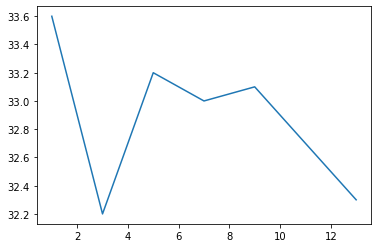

In [470]:
model_knn_pred = Knn(X_train_rgb,X_val_rgb,y_train,y_val)

              precision    recall  f1-score   support

           0       0.40      0.50      0.45       973
           1       0.79      0.15      0.25       979
           2       0.23      0.43      0.30      1030
           3       0.33      0.19      0.24      1023
           4       0.21      0.53      0.30       933
           5       0.41      0.20      0.27      1015
           6       0.33      0.27      0.30       996
           7       0.70      0.16      0.26       994
           8       0.36      0.70      0.47      1017
           9       0.66      0.12      0.21      1040

    accuracy                           0.32     10000
   macro avg       0.44      0.32      0.30     10000
weighted avg       0.44      0.32      0.30     10000



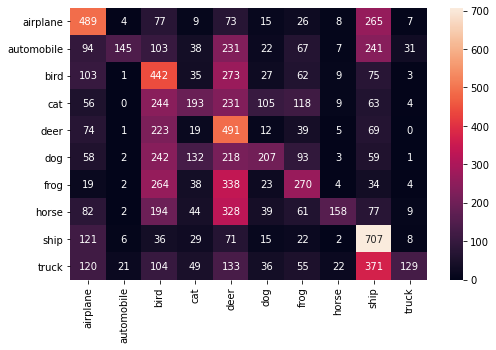

In [471]:
confmat_knn = confusion_matrix(y_val, model_knn_pred)
print(classification_report(y_val, model_knn_pred))
plot_confusion_mat(confmat_knn,class_names)

#### Logistic Regression

In that model, we tried several options of iterations and saw it does not increase the score in some point

We can also check overfitting as can seen in the plot. but we dont see that the model is fit well for the data, while the test set decreases 

In [602]:
model_lr_pred = LR(X_train_rgb,X_val_rgb,y_train,y_val)

20 iterations: Validation set - The Accuracy score is: 36.7%
20 iterations: Training set - The Accuracy score is: 37.0%
50 iterations: Validation set - The Accuracy score is: 40.1%
50 iterations: Training set - The Accuracy score is: 40.8%
80 iterations: Validation set - The Accuracy score is: 40.699999999999996%
80 iterations: Training set - The Accuracy score is: 42.699999999999996%
110 iterations: Validation set - The Accuracy score is: 41.0%
110 iterations: Training set - The Accuracy score is: 43.6%
140 iterations: Validation set - The Accuracy score is: 41.699999999999996%
140 iterations: Training set - The Accuracy score is: 44.5%


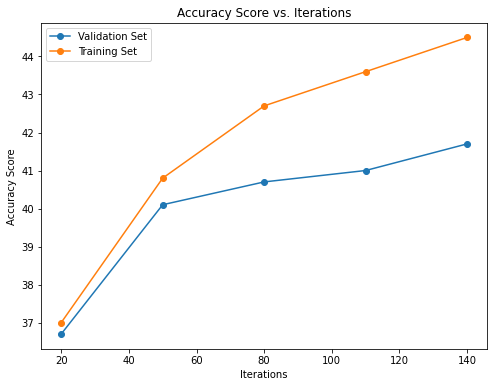

In [603]:
# Accuracy scores for different iterations and datasets
iterations = [20, 50, 80, 110, 140]
validation_scores = [36.7, 40.1, 40.7, 41.0, 41.7]
training_scores = [37.0, 40.8, 42.7, 43.6, 44.5]

# Plot the accuracy scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, validation_scores, label='Validation Set', marker='o')
plt.plot(iterations, training_scores, label='Training Set', marker='o')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs. Iterations')
plt.legend()

# Show the plot
plt.show()

- We can see clearly no overfitting

              precision    recall  f1-score   support

           0       0.43      0.48      0.46       973
           1       0.46      0.50      0.48       979
           2       0.36      0.32      0.34      1030
           3       0.32      0.29      0.30      1023
           4       0.38      0.28      0.33       933
           5       0.33      0.31      0.32      1015
           6       0.42      0.52      0.47       996
           7       0.45      0.46      0.45       994
           8       0.51      0.53      0.52      1017
           9       0.47      0.49      0.48      1040

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



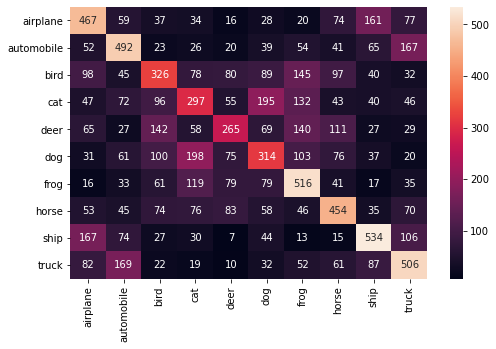

In [604]:
confmat_lr = confusion_matrix(y_val, model_lr_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, model_lr_pred))

#### Decision tree

- We ran the model with deeper depth but it is just did not stopped, and the we make it 20, it got the best score

In [589]:
model_dt_pred = Decision_tree(X_train_rgb,X_val_rgb,y_train,y_val)

The Accuracy score for Decision tree Model is: 26.200000000000003%


              precision    recall  f1-score   support

           0       0.32      0.36      0.34       973
           1       0.28      0.26      0.27       979
           2       0.20      0.20      0.20      1030
           3       0.19      0.20      0.20      1023
           4       0.21      0.25      0.23       933
           5       0.21      0.20      0.21      1015
           6       0.28      0.27      0.27       996
           7       0.25      0.25      0.25       994
           8       0.37      0.36      0.36      1017
           9       0.32      0.28      0.29      1040

    accuracy                           0.26     10000
   macro avg       0.26      0.26      0.26     10000
weighted avg       0.26      0.26      0.26     10000



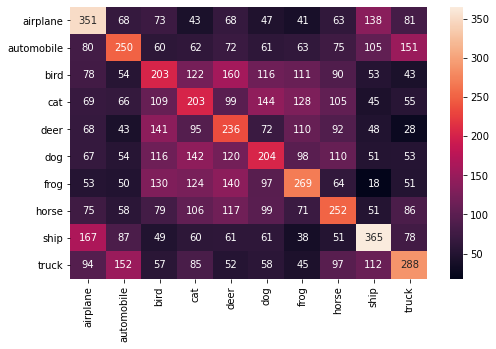

In [590]:
confmat_lr = confusion_matrix(y_val, model_dt_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, model_dt_pred))

### Discussion on the model scores

#### KNN
- KNN considers only local information from its K nearest neighbors, which may not capture global patterns effectively for complex datasets like CIFAR-10. We can also see that the best k is 1, which reproduces the hypothesis.

- As the number of dimensions grows, the number of possible combinations and distances between data points increases exponentially. This leads to a significant increase in computational complexity when searching for the K nearest neighbors. And also, all data points tend to be equidistant from each other, which makes it difficult for KNN to identify meaningful patterns or neighbors.

- Note: The model recognizes labels of the same types quite well, for example airplane - the model recognize correctly 461 samples, but 211 as ship (vehicles). Cat - 226 correctly and the results in the absolute majority recognized also as types of animals. And so on. Although automobile recognized like deer more than automobile. The model recognized a lot of samples as bird and dog

#### Logistic regression

- Logistic regression is a linear model, and it can only learn linear decision boundaries. CIFAR-10 images are complex, and their features are highly non-linear. As a result, logistic regression may struggle to capture the intricate relationships between pixels and classes.

- Logistic Regression can only model simple relationships between input features and output classes. It might struggle to learn the complex hierarchical features that are essential for image recognition tasks.

- Note: Here the scores are better, and each label received the most votes for it. Here we can see better separation of animal and vehicle. Also here cat and dog recognized like each other.

#### Decision tree
- The model produced a relatively low result. This happens because the tree depth is limited, it may not have enough capacity to learn intricate patterns in the data and also because The curse of dimensionality can negatively impact Decision Trees, particularly when working with high-dimensional data like images.
- Note: Although the model got lower score, he still recognize the same type well. but he is struggle a lot to recognize the exact animal and the exact vehicle. It is more prominent than the other models.

## Moving to grayscale

- Now we will check the images converting to grayscale. We would assume that the scores will be lower, because  RGB images provide more information about the color content, which can be useful for distinguishing objects with distinct color patterns. 

- On the other hand, Grayscale images might provide simpler and more compact features compared to RGB images. In some cases, grayscale images can still contain sufficient information for image classification, especially when color is not a critical factor in distinguishing between classes. Its kind of PCA.


In [591]:
x_train_gray = rgb2gray(x_train)
x_val_gray = rgb2gray(x_val)
x_test_gray = rgb2gray(x_test)

#### Lets take a look on some grayscale images

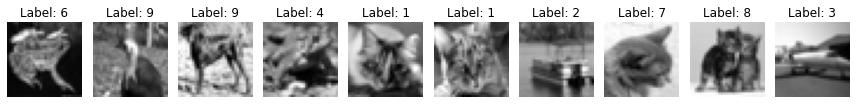

In [593]:
num_images_to_plot = 10
plt.figure(figsize=(12, 6))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(x_train_gray[i], cmap='gray')
    plt.title(f'Label: {y_train_full[i][0]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

After seeing, we thing the color is important for us, hence the results will be lower

In [594]:
# Organize the data
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_val_gray = x_val_gray.reshape(x_val_gray.shape[0], -1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], -1)

In [595]:
# Scaling
scale(x_train_gray,x_val_gray,x_test_gray)

### Models

We ran the model with same parameters as before, to make a fair comparison

#### KNN

The Accuracy score for 1 nearest neighbers is: 28.7%


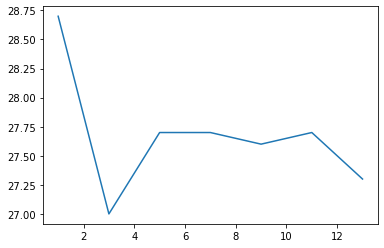

In [596]:
model_knn_pred = Knn(x_train_gray,x_val_gray,y_train,y_val)

- The results are less good

              precision    recall  f1-score   support

           0       0.25      0.41      0.31       973
           1       0.68      0.14      0.23       979
           2       0.21      0.36      0.26      1030
           3       0.29      0.14      0.19      1023
           4       0.18      0.43      0.25       933
           5       0.43      0.17      0.25      1015
           6       0.28      0.20      0.23       996
           7       0.74      0.13      0.23       994
           8       0.29      0.62      0.40      1017
           9       0.67      0.13      0.22      1040

    accuracy                           0.27     10000
   macro avg       0.40      0.27      0.26     10000
weighted avg       0.40      0.27      0.26     10000



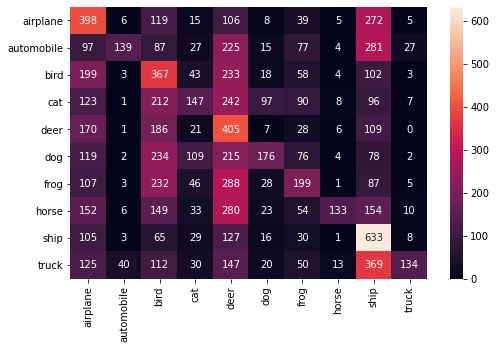

In [597]:
confmat_knn = confusion_matrix(y_val, model_knn_pred)
print(classification_report(y_val, model_knn_pred))
plot_confusion_mat(confmat_knn,class_names)

#### Logistic regression

In [598]:
model_lr_pred = LR(x_train_gray,x_val_gray,y_train,y_val)

20 iterations: Validation set - The Accuracy score is: 28.199999999999996%
20 iterations: Training set - The Accuracy score is: 28.499999999999996%
50 iterations: Validation set - The Accuracy score is: 28.4%
50 iterations: Training set - The Accuracy score is: 29.9%
80 iterations: Validation set - The Accuracy score is: 28.599999999999998%
80 iterations: Training set - The Accuracy score is: 30.599999999999998%
110 iterations: Validation set - The Accuracy score is: 28.199999999999996%
110 iterations: Training set - The Accuracy score is: 31.1%
140 iterations: Validation set - The Accuracy score is: 27.800000000000004%
140 iterations: Training set - The Accuracy score is: 31.2%


              precision    recall  f1-score   support

           0       0.22      0.28      0.25       973
           1       0.34      0.38      0.36       979
           2       0.27      0.17      0.20      1030
           3       0.22      0.16      0.18      1023
           4       0.23      0.17      0.19       933
           5       0.24      0.27      0.25      1015
           6       0.27      0.24      0.25       996
           7       0.28      0.28      0.28       994
           8       0.27      0.38      0.32      1017
           9       0.41      0.45      0.43      1040

    accuracy                           0.28     10000
   macro avg       0.27      0.28      0.27     10000
weighted avg       0.27      0.28      0.27     10000



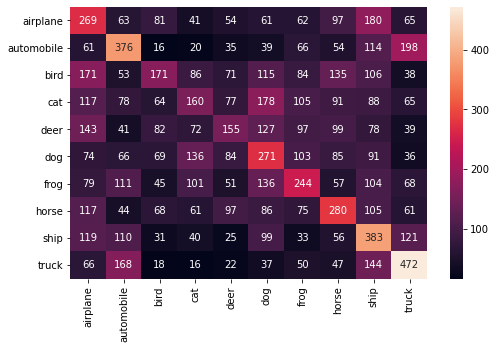

In [599]:
confmat_lr = confusion_matrix(y_val, model_lr_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, model_lr_pred))

#### Decision tree

In [600]:
model_dt_pred = Decision_tree(x_train_gray,x_val_gray,y_train,y_val)

The Accuracy score for Decision tree Model is: 22.5%


              precision    recall  f1-score   support

           0       0.24      0.26      0.25       973
           1       0.27      0.27      0.27       979
           2       0.19      0.21      0.20      1030
           3       0.17      0.16      0.16      1023
           4       0.17      0.20      0.18       933
           5       0.20      0.19      0.19      1015
           6       0.19      0.19      0.19       996
           7       0.26      0.24      0.25       994
           8       0.31      0.30      0.31      1017
           9       0.28      0.23      0.25      1040

    accuracy                           0.22     10000
   macro avg       0.23      0.22      0.23     10000
weighted avg       0.23      0.22      0.23     10000



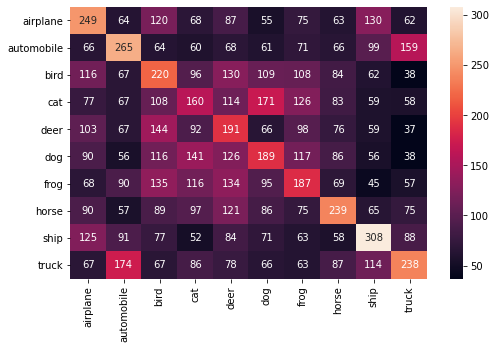

In [601]:
confmat_lr = confusion_matrix(y_val, model_dt_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, model_dt_pred))

### Discussion on the model scores

- As we can see, the results are even worst than before.
- We assume that the color is very important
- Moreover, for all the models we see mixing results between the types (vehicles vs animals)


### PCA

We decided to check another way to reduce the dim.
We have a lot of features and we need a way to prevent the important features, while runnung models in efficient way.

The primary goal of PCA is to transform the original feature space into a new set of uncorrelated variables, called principal components, while retaining as much information as possible. By doing so, PCA not only reduces the dimensionality of the dataset but also enhances the interpretability of the data. This reduction in dimensionality allows us to work with a more manageable and compact representation of the data, making the models more tractable and computationally efficient.

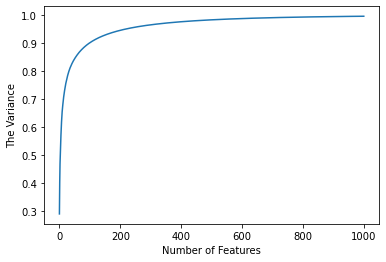

In [78]:
pca = PCA(n_components= 1000).fit(X_train_rgb)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Features")
plt.ylabel("The Variance")
plt.show()

In [79]:
preprocess = Pipeline([('scaler', StandardScaler(with_std=False)), ('pca', PCA(n_components = 0.90))])
x_train_reduced_95 = preprocess.fit_transform(X_train_rgb)
x_val_reduced_95 = preprocess.transform(X_val_rgb)


We can see that 99 n_components 90% of variance that should be preserved in the transformed data. In other words, PCA will retain the minimum number of principal components needed to explain n_components amount of the total variance in the original data. We will go with that

### Models on the reduced data

So after all the explanations, we are back now to the original images after PCA

### KNN

The Accuracy score for 1 nearest neighbers is: 37.4%


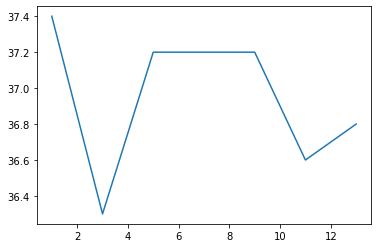

In [607]:
model_knn_pred = Knn(x_train_reduced_95,x_val_reduced_95,y_train,y_val)

              precision    recall  f1-score   support

           0       0.42      0.54      0.47       973
           1       0.68      0.26      0.38       979
           2       0.25      0.41      0.31      1030
           3       0.35      0.17      0.23      1023
           4       0.24      0.52      0.33       933
           5       0.47      0.22      0.30      1015
           6       0.32      0.45      0.38       996
           7       0.65      0.24      0.35       994
           8       0.42      0.66      0.51      1017
           9       0.67      0.23      0.34      1040

    accuracy                           0.37     10000
   macro avg       0.45      0.37      0.36     10000
weighted avg       0.45      0.37      0.36     10000



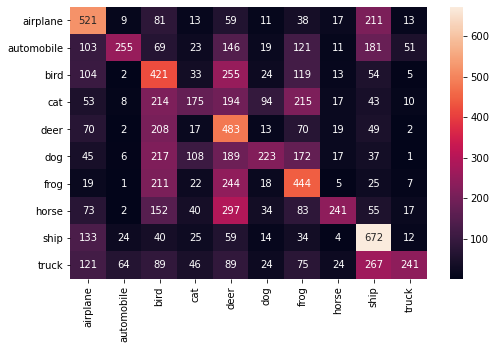

In [608]:
confmat_lr = confusion_matrix(y_val, model_knn_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, model_knn_pred))

### Logistic regression

In [609]:
model_lr_pred = LR(x_train_reduced_95,x_val_reduced_95,y_train,y_val)

20 iterations: Validation set - The Accuracy score is: 39.5%
20 iterations: Training set - The Accuracy score is: 40.1%
50 iterations: Validation set - The Accuracy score is: 39.7%
50 iterations: Training set - The Accuracy score is: 40.5%
80 iterations: Validation set - The Accuracy score is: 39.6%
80 iterations: Training set - The Accuracy score is: 40.5%
110 iterations: Validation set - The Accuracy score is: 39.6%
110 iterations: Training set - The Accuracy score is: 40.5%
140 iterations: Validation set - The Accuracy score is: 39.6%
140 iterations: Training set - The Accuracy score is: 40.5%


              precision    recall  f1-score   support

           0       0.41      0.46      0.44       973
           1       0.44      0.50      0.47       979
           2       0.32      0.25      0.28      1030
           3       0.30      0.27      0.28      1023
           4       0.34      0.30      0.32       933
           5       0.34      0.33      0.33      1015
           6       0.41      0.49      0.45       996
           7       0.42      0.41      0.42       994
           8       0.49      0.49      0.49      1017
           9       0.45      0.46      0.45      1040

    accuracy                           0.40     10000
   macro avg       0.39      0.40      0.39     10000
weighted avg       0.39      0.40      0.39     10000



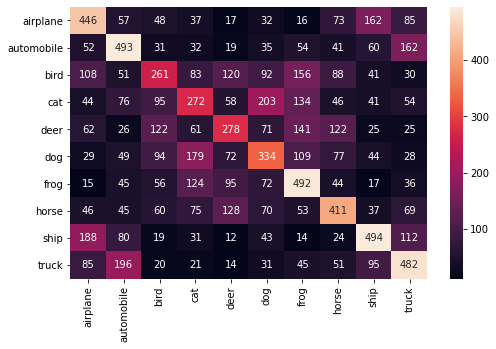

In [610]:
confmat_lr = confusion_matrix(y_val, model_lr_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, model_lr_pred))

In [663]:
model_dt_pred = Decision_tree(x_train_reduced_95,x_val_reduced_95,y_train,y_val)

The Accuracy score for Decision tree Model is: 26.700000000000003%


              precision    recall  f1-score   support

           0       0.33      0.35      0.34       973
           1       0.32      0.31      0.31       979
           2       0.21      0.21      0.21      1030
           3       0.18      0.18      0.18      1023
           4       0.23      0.26      0.24       933
           5       0.23      0.22      0.22      1015
           6       0.27      0.28      0.28       996
           7       0.24      0.22      0.23       994
           8       0.38      0.38      0.38      1017
           9       0.30      0.26      0.28      1040

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.27     10000
weighted avg       0.27      0.27      0.27     10000



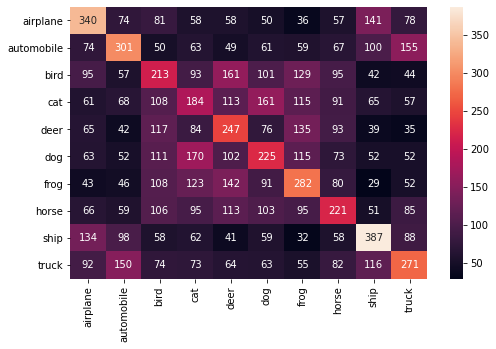

In [664]:
confmat_lr = confusion_matrix(y_val, model_dt_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, model_dt_pred))

### SVM

svm model can also work in several forms. We will not present its linear form now because we have already run a lot of linear models.

We chose to check the "kernel" and "c" parameters.
The kernel runs by function. We chose to send him "poly" and "RBF". The polynomial kernel allows the SVM to learn non-linear decision boundaries by transforming the data into a higher dimensional space. The degree of the polynomial is a hyperparameter and it controls the flexibility of the model in creating non-linear boundaries. The RBF core transforms the data into an infinite dimensional space, enabling highly flexible and complex decision boundaries.
The RBF kernel has a hyperparameter called gamma (γ), which controls the effect of each training example on the decision boundary.

the parameter 'C' is the regularization parameter. It controls the trade-off between maximizing the margin (decision boundary) and minimizing the classification error on the training data. A smaller value of 'C' allows for a larger margin but might tolerate some misclassifications on the training set (soft margin), while a larger 'C' value enforces a stricter margin and aims to minimize training errors (hard margin).

In [666]:
val_pred = SVM(x_train_reduced_95,x_val_reduced_95,y_train,y_val)

poly kernel with 0.1 Regularization parameter gave score of: 0.3883
poly kernel with 1.0 Regularization parameter gave score of: 0.4527
poly kernel with 2.0 Regularization parameter gave score of: 0.4612
poly kernel with 5.0 Regularization parameter gave score of: 0.4664
rbf kernel with 0.1 Regularization parameter gave score of: 0.449
rbf kernel with 1.0 Regularization parameter gave score of: 0.5258
rbf kernel with 2.0 Regularization parameter gave score of: 0.5425
rbf kernel with 5.0 Regularization parameter gave score of: 0.5544


              precision    recall  f1-score   support

           0       0.59      0.63      0.61       973
           1       0.65      0.67      0.66       979
           2       0.44      0.42      0.43      1030
           3       0.40      0.41      0.41      1023
           4       0.45      0.48      0.47       933
           5       0.47      0.43      0.45      1015
           6       0.56      0.62      0.59       996
           7       0.64      0.57      0.60       994
           8       0.70      0.71      0.70      1017
           9       0.65      0.60      0.62      1040

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



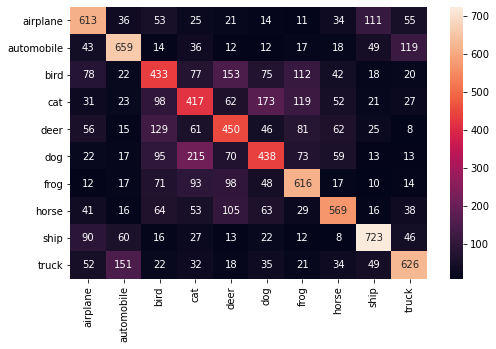

In [667]:
confmat_lr = confusion_matrix(y_val, val_pred)
plot_confusion_mat(confmat_lr,class_names)

print(classification_report(y_val, val_pred))

### Discussion on the model scores

You can see better results for some models now, than the results on the original data.

- We think the reason might be that as the number of features (dimensions) in the dataset increases, data points become sparse     and the much more complex to analyze,
  making it difficult for algorithms to find meaningful patterns or neighbors. So PCA helps them to find those connections.

- Another thing is, that PCA can lead to more meaningful distance metrics, making the algorithms more effective, because in high-dimensional spaces, the concept of distance becomes less meaningful.

- Moreover,  PCA can help remove some of this noise by retaining only the most important components.

- KNN - the scores are quite better, but in the confusion matrix there is no significant change. The distribution is similar.

- LR and Decision tree - the scores is similar.

- SVM - Got the highest score - 55% with 'rbf' kernel and c = 5. It can seen immidiately that he is the best, but he struggled to distinguish between dog and cat. Its an approval that non-linear function work better on this dataset.

- We will continue with this reduced data 

<font size="10"><h1><center>Animal vs Vehicle</center></h1></font>

<div>
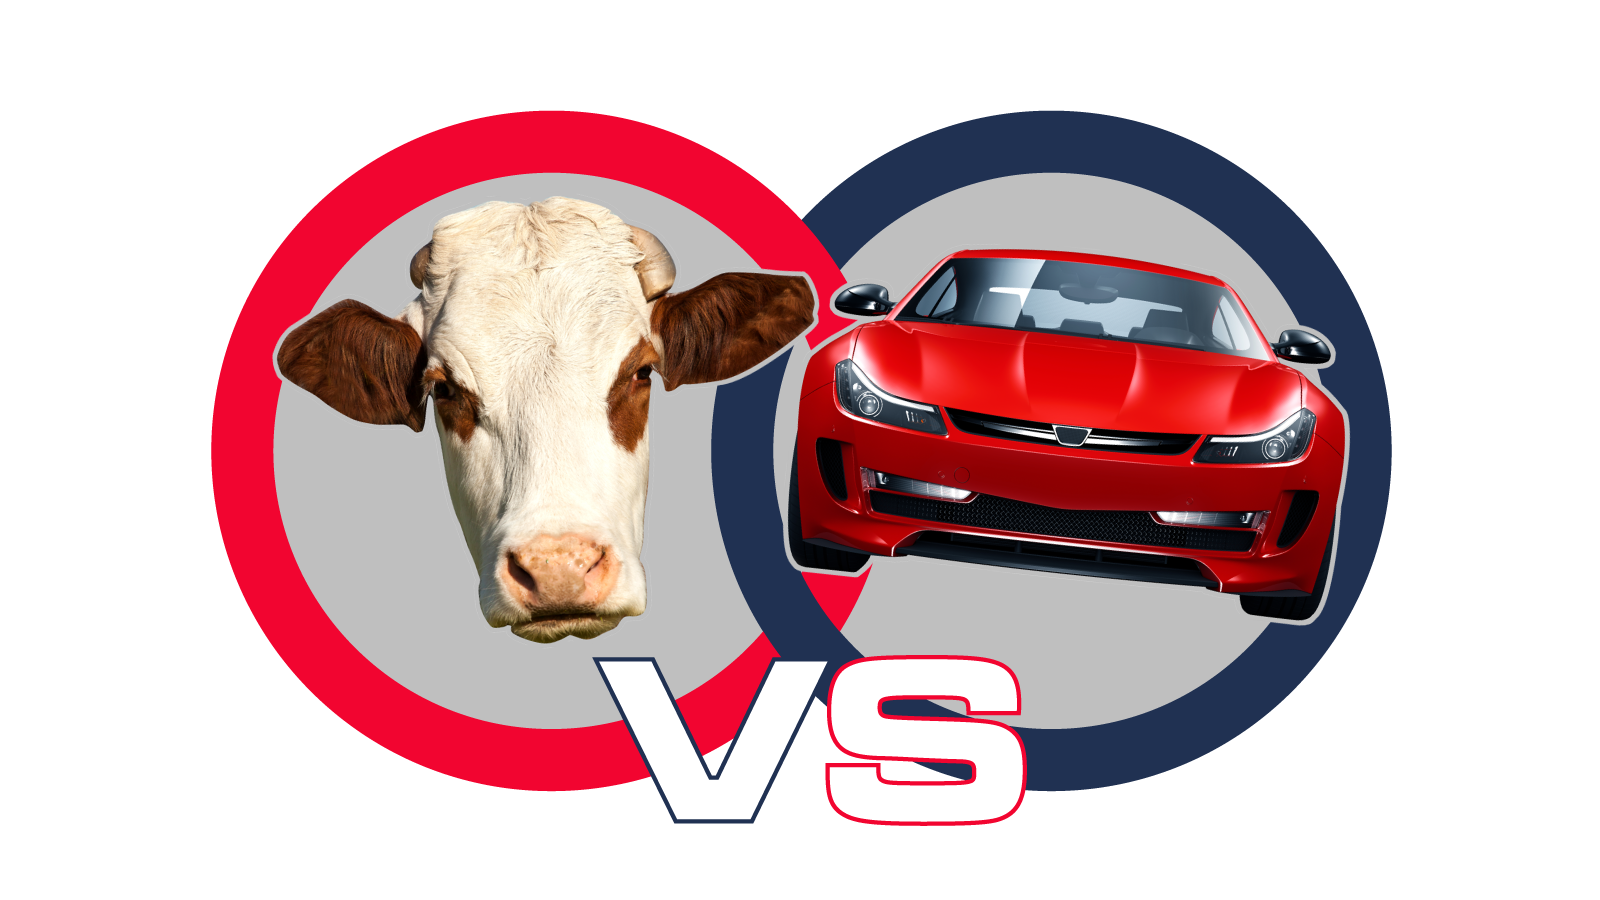
</div>

The data is divided into animals and vehicles. Another thing we would like to investigate is how well the model classifies between the two. As we have seen, the models did not achieve high results, but they know how to differentiate a lot between the two types.

In [81]:
class_names_2 = ['vehicle', 'animal']

In [88]:
label_mapping = {
    0: 0,
    1: 0,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 0,
    9: 0,
}

# Replace the specific labels in the DataFrame with the new label values
df['label'] = df['label'].astype(int)
df_2 = df.copy()
df_2['label'] = df_2['label'].replace(label_mapping)

In [89]:
round(df_2["label"].value_counts()/len(df_2["label"])*100,4)

1    60.0
0    40.0
Name: label, dtype: float64

### Distribution of the data

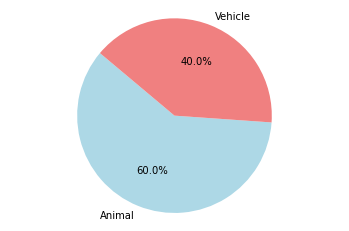

In [90]:
labels = ['Animal', 'Vehicle']
sizes = [60.0, 40.0]
colors = ['lightblue', 'lightcoral']
# Plot the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
# Display the pie chart
plt.show()

In [91]:
x_train_2 = df_2.drop(["label"], axis = 1)
y_train_2 = df_2["label"]

In [92]:
# transfer the data to be in numpy type, to future modeling
x_train_pair = x_train_2.values
y_train_pair = y_train_2.values


In [94]:
x_train_rgb_2, x_val_rgb_2, y_train_pair, y_val_pair = train_test_split(x_train_pair, y_train_pair, test_size=0.2, random_state=42)


In [634]:
preprocess = Pipeline([('scaler', StandardScaler(with_std=False)), ('pca', PCA(n_components = 0.90))])
x_train_rgb_22 = preprocess.fit_transform(x_train_rgb_2)
x_val_rgb_22 = preprocess.transform(x_val_rgb_2)

In [635]:
x_train_rgb_22 = x_train_rgb_2.reshape(x_train_rgb_2.shape[0], -1)
x_val_rgb_22 = x_val_rgb_2.reshape(x_val_rgb_2.shape[0], -1)

y_train_pair = np.squeeze(y_train_pair)
y_val_pair = np.squeeze(y_val_pair)

In [636]:
scale(x_train_rgb_22,x_val_rgb_22,X_test_rgb)

### Models

### KNN

The Accuracy score for 4 nearest neighbers is: 82.39999999999999%


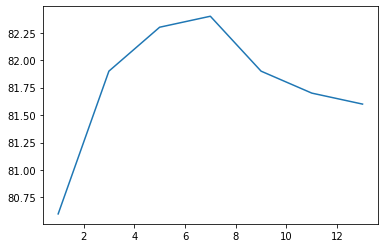

In [640]:
model_knn_pred = Knn(x_train_reduced_95,x_val_reduced_95,y_train_pair,y_val_pair)

              precision    recall  f1-score   support

           0       0.84      0.67      0.74      4009
           1       0.80      0.92      0.86      5991

    accuracy                           0.82     10000
   macro avg       0.82      0.79      0.80     10000
weighted avg       0.82      0.82      0.81     10000



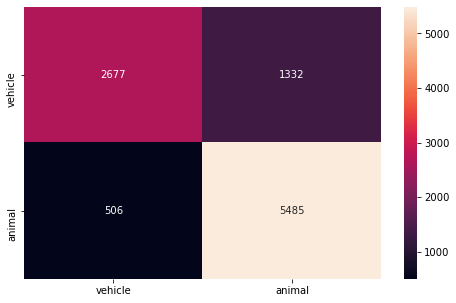

In [652]:
confmat_lr = confusion_matrix(y_val_pair, model_knn_pred)
plot_confusion_mat2(confmat_lr,class_names_2)

print(classification_report(y_val_pair, model_knn_pred))

### Logistic regression

In [97]:
model_lr_pred = LR2(x_train_reduced_95,x_val_reduced_95,y_train_pair,y_val_pair)

20 iterations: Validation set - The Accuracy score is: 79.5%
20 iterations: Training set - The Accuracy score is: 79.80000000000001%
70 iterations: Validation set - The Accuracy score is: 81.6%
70 iterations: Training set - The Accuracy score is: 81.3%
120 iterations: Validation set - The Accuracy score is: 82.19999999999999%
120 iterations: Training set - The Accuracy score is: 81.8%
170 iterations: Validation set - The Accuracy score is: 82.19999999999999%
170 iterations: Training set - The Accuracy score is: 81.8%
220 iterations: Validation set - The Accuracy score is: 82.19999999999999%
220 iterations: Training set - The Accuracy score is: 81.8%
270 iterations: Validation set - The Accuracy score is: 82.19999999999999%
270 iterations: Training set - The Accuracy score is: 81.8%
320 iterations: Validation set - The Accuracy score is: 82.19999999999999%
320 iterations: Training set - The Accuracy score is: 81.8%
370 iterations: Validation set - The Accuracy score is: 82.1999999999999

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      4009
           1       0.83      0.88      0.86      5991

    accuracy                           0.82     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.82      0.82     10000



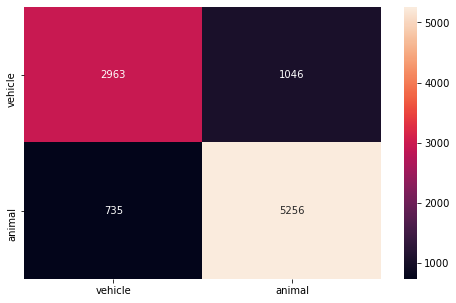

In [653]:
confmat_lr = confusion_matrix(y_val_pair, model_lr_pred)
plot_confusion_mat(confmat_lr,class_names_2)

print(classification_report(y_val_pair, model_lr_pred))

### Decision tree

In [654]:
model_dt_pred = Decision_tree(x_train_reduced_95,x_val_reduced_95,y_train_pair,y_val_pair)

The Accuracy score for Decision tree Model is: 75.3%


              precision    recall  f1-score   support

           0       0.70      0.68      0.69      4009
           1       0.79      0.80      0.80      5991

    accuracy                           0.75     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.75      0.75      0.75     10000



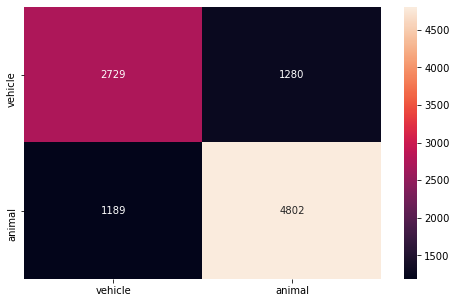

In [656]:
confmat_lr = confusion_matrix(y_val_pair, model_dt_pred)
plot_confusion_mat(confmat_lr,class_names_2)

print(classification_report(y_val_pair, model_dt_pred))

### SVM

Validation:
poly kernel with 0.1 Regularization parameter gave score of: 0.6594
Train:
poly kernel with 0.1 Regularization parameter gave score of: 0.6602
Validation:
poly kernel with 1.0 Regularization parameter gave score of: 0.725
Train:
poly kernel with 1.0 Regularization parameter gave score of: 0.739625
Validation:
poly kernel with 2.0 Regularization parameter gave score of: 0.7332
Train:
poly kernel with 2.0 Regularization parameter gave score of: 0.76035
Validation:
poly kernel with 5.0 Regularization parameter gave score of: 0.7182
Train:
poly kernel with 5.0 Regularization parameter gave score of: 0.762225


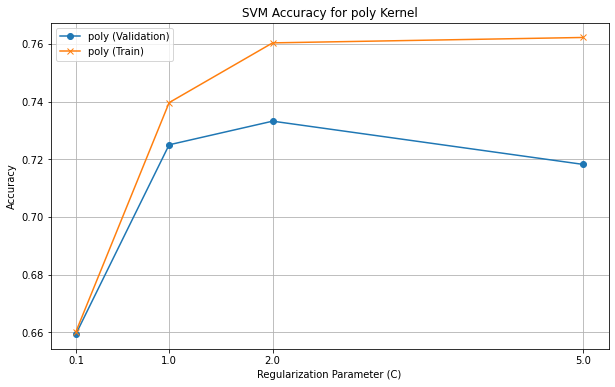

Validation:
rbf kernel with 0.1 Regularization parameter gave score of: 0.8586
Train:
rbf kernel with 0.1 Regularization parameter gave score of: 0.863075
Validation:
rbf kernel with 1.0 Regularization parameter gave score of: 0.887
Train:
rbf kernel with 1.0 Regularization parameter gave score of: 0.919875
Validation:
rbf kernel with 2.0 Regularization parameter gave score of: 0.8907
Train:
rbf kernel with 2.0 Regularization parameter gave score of: 0.93955
Validation:
rbf kernel with 5.0 Regularization parameter gave score of: 0.8931
Train:
rbf kernel with 5.0 Regularization parameter gave score of: 0.96995


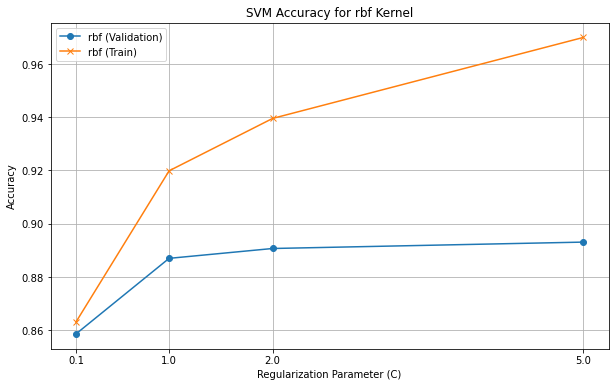

In [114]:
val_pred = SVM2(x_train_reduced_95, x_val_reduced_95, y_train_pair, y_val_pair)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4009
           1       0.90      0.92      0.91      5991

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



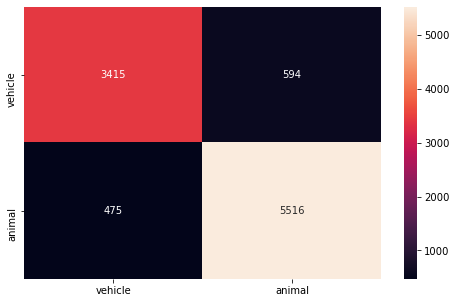

In [115]:
confmat_lr = confusion_matrix(y_val_pair, val_pred)
plot_confusion_mat(confmat_lr,class_names_2)

print(classification_report(y_val_pair, val_pred))

### Discussion on the model scores

- Now the scores are much better. We saw before that although the scores was less than 50%, In the vast majority of times the models did not classify an animal as a vehicle and vice versa. So we are not surprised that the scores now are much better.


- Still, the results are between 75%-90% which is not perfect, but we think it can be understood, because still this separation the those 2 is not completeley linear, and there are models that classified animal as vehicle and vice versa 


- The best score was SVM using 'rbf' kernel, with C of 5 with 89%. We saw before in the confusion matrix that this model classified the best between the 2 types. The errors were quite equal in both directions. But we have noticed that for C 5 we may get into overfitting, so we used rbf with C = 2.


- KNN got 83%. We can see that he classified 2 times vehicles as animlas than the opposite.


- LR got a 1% less. But, he classified more vehicles correctly.


- Decision tree got 75%. The errors were quite equal in both directions.


- We can assume animals are similar for each other than vehicles. It makes sense because animals maybe in same size, or same colors. But vehicles maybe in less same size and colors. 


### CNN

- Back to 10 labels. Now we will check with model that we did not learned. This model more suitable for image classification

- Convolutional Neural Networks (CNNs) are a type of deep learning model that can automatically learn hierarchical representations of the input data by using convolutional layers, pooling layers, and fully connected layers. CNNs are particularly well-suited for image classification tasks, where the spatial relationships between the pixels are important.


- We will try to use different parameters and techniques. Also, we know the power of NN and if the model will be too complex it can cause overfitting, because we have only 60,000 images(we read that this is not so much)

- We will also want to see the how this model dealing with similar classes (e.g., "truck" and "automobile")

In [56]:
# Convert labels to one-hot encoding - helps to the predictions
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


### Lets try first model - shallow

In [553]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data= (x_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_val, y_val)
print("Test accuracy:", test_acc)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_7 (Flatten)         (None, 1024)             

- The score on the validation set with this simple CNN gave us already the best score of about 65%. But let's notice on the scores towards the epochs

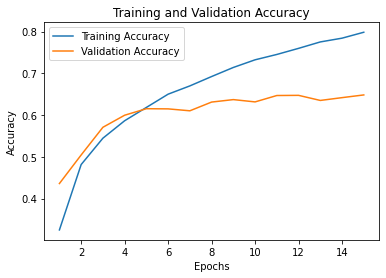

In [555]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- It can seen that as long the epochs goes the training is better and better and increasing while the validation is pretty much remains the same. This thing may imply to us about overfitting, beacuse if we will continue with the epochs, it is probable that the training will be almost perfect, while the val remains low all over the epochs, which means our model adapted to the training set.


To overcome this, we learned about NN and how to deal with overfitting.
We saw the technique called 'Dropout'. During training, dropout randomly sets a fraction of the neurons' activations to zero, effectively "dropping out" those neurons temporarily. This means that for each forward pass during training, different subsets of neurons are dropped out, which helps to prevent the network from relying too heavily on specific neurons or features and be more general.

In [46]:

#The second model with dropout of 0.5
model2 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model2.summary()

# Train the model
history2 = model2.fit(x_train, y_train, epochs=10, batch_size=64, validation_data= (x_val, y_val))

# make predictions on the validation data
cnn1 = model2.predict(x_val)

# convert the one hot encoded back to regular (so we can calculate the accuracy score and present the confusion matrix)
cnn1 = np.argmax(cnn1, axis=1)
y_val = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_val, cnn1)


# calculate the accuracy score
cnn1_val_acc = accuracy_score(y_val, cnn1)
print('cnn1 validation accuracy:', cnn1_val_acc)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 flatten_12 (Flatten)        (None, 2048)            

- Now the score is better by 3%. Let's check overfitting

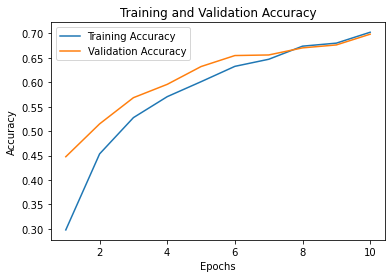

In [47]:
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It can be seen that we managed to avoid overfitting using dropout.The model is more general and adapted less to the training data

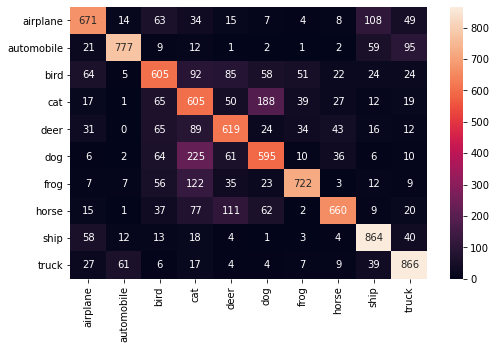

In [48]:
plot_confusion_mat(conf_matrix,class_names)

- The score is the best so far.
- We can see great classifying according animals vs vehicles.
- Most of the classiying is good but there are some big mistakes
- Moreover, inside each type, the model classified vehicles better than animals. Actually, we saw each in almost all the models. We can understand that, because most of the animals in the data are similar than the vehicles

In [58]:
# The revised model with batch normalization and fewer pooling layers
model_revised3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    

    
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_revised3.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print the model summary
model_revised3.summary()

# Train the model
history_revised = model_revised3.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

# Make predictions on the validation data
cnn_revised_val_pred = model_revised3.predict(x_val)

# Convert the one-hot encoded back to regular labels
cnn_revised_val_pred = np.argmax(cnn_revised_val_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
conf_matrix_revised = confusion_matrix(y_val_labels, cnn_revised_val_pred)

# Calculate the accuracy score
cnn_revised_val_acc = accuracy_score(y_val_labels, cnn_revised_val_pred)
print('Revised CNN with Batch Normalization and fewer pooling layers validation accuracy:', cnn_revised_val_acc)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_75 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_76 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                     

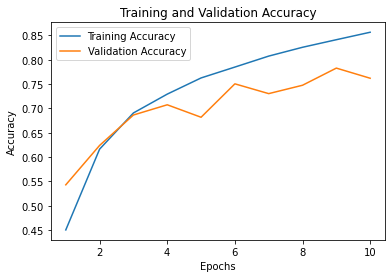

In [59]:
train_acc = history_revised.history['accuracy']
val_acc = history_revised.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- We stopped after 10 epochs because from then on it may be overfitted.

### Final prediction on the test

In [61]:
# make predictions on the test data
cnn_test = model_revised3.predict(x_test)

# convert the one hot encoded back to regular (so we can calculate the accuracy score and present the confusion matrix)
cnn_test = np.argmax(cnn_test, axis=1)
y_test = np.argmax(y_test, axis=1)

# calculate the accuracy score
cnn2_test_acc = accuracy_score(y_test, cnn_test)
print('cnn test accuracy:', cnn2_test_acc)

conf_matrix = confusion_matrix(y_test, cnn_test)

313/313 [==============================] - 3s 11ms/step
cnn test accuracy: 0.759


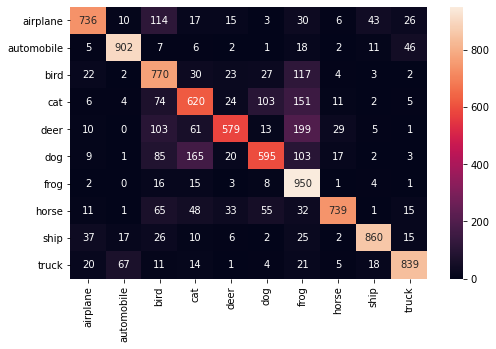

In [62]:
plot_confusion_mat(conf_matrix,class_names)

- The result is much better. The changes are minoric. we can see that he separated well between the types. We can say that some animals looks very similar and maybe we need to modify the model to get better with that.
- We got the best score of 76%

### Summary

- The project was a lot of fun, and we learned a lot from it. We answered questions we wanted to investigate and tried to understand why the results came out in a certain way and how we could improve. We went deeper and it was very instructive.



1. We loaded the data into the notebook and presented it in two different resolutions
2. We analyzed the data and checked whether it is balanced, arranged and preapare the data 
3. We ran models on the images in RGB format(original).
4. We ran models on the images in GRAY format.
5. We decided to use the PCA method to select the best components for the model and increase the efficiency.
6. We ran the models on the images in RGB format after reducing the components. 
7. We decided to explore the data in a different way. Instead of having 10 classes, we united the groups into 2 classes. Animals VS Vehicles.
8. We ran the models on the updated data.
9. We checked what happens when running a neural network on the data, we used CNN.

- We dabbled in data with many labels and features. We tried the traditional and simpler methods, and we saw that they fail to classify well. This worked out with the assumption that the data was non-linear.

- We used dimensionality reduction to extract the important features, and we saw that when running svm the results improved a bit when we used a non-linear function.

- Along the way, we saw that the models do succeed in classifying animals versus vehicles in a good way, so we wanted to confirm this assumption, and indeed we saw good results.

- Finally, we used cnn, a network that is more suitable for our data and indeed the results improved by about 20%.

- We faced problems such as long running times, non-linearity, multiclass, overfitting and more.